# Main Plots For Quantum Deep Learning Work

In [1]:

import importlib
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from copy import deepcopy
from decimal import Decimal, getcontext, DecimalException
from scipy.optimize import curve_fit
from matplotlib.font_manager import FontProperties
import quantum_dl_lib
importlib.reload(quantum_dl_lib)
from quantum_dl_lib import *


In [2]:
surface_code_formula(10**-2.5)
classical_runtime = "n"
quantum_runtime = "log(n,2)"
# Calculate the quantum advantage size for each year
classical_alg_overhead = 1e4

print(quantum_advantage_size_by_year(2027, classical_runtime, quantum_runtime))
print("largest problem size", find_largest_problem_size(quantum_runtime, 2027, quantum=True))

179784054941097.94
largest problem size 1.1482837221510422


/Users/hansgundlach/Documents/AllOtherResearch/NeelMaterial/othello/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


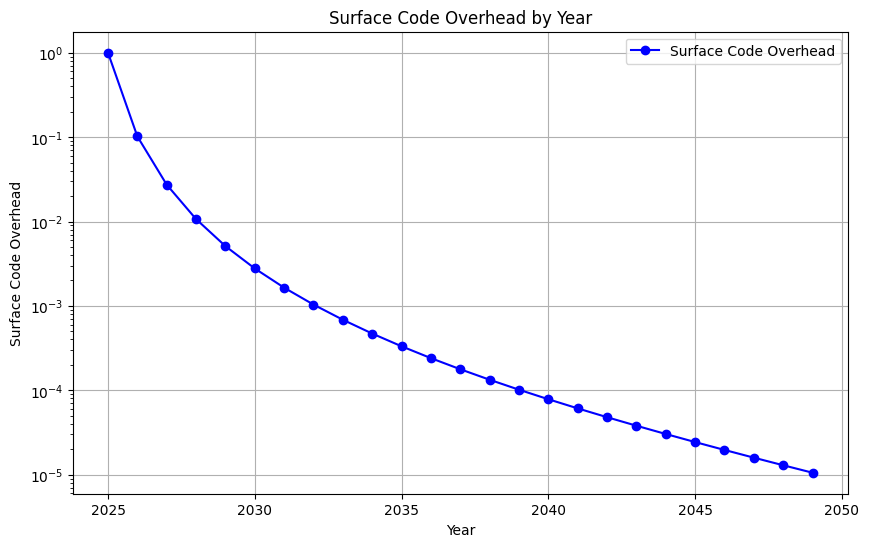

1.0
1.0


In [3]:
# graph suface code overhead over time
years = np.arange(2025, 2050)
surface_code_overhead_init = surface_code_formula(initial_error*fidelity_improvement_rate**(2025-2025))
surface_code_overhead_list = [(surface_code_formula(initial_error*fidelity_improvement_rate**(year-2025))/surface_code_formula(initial_error))**1.5 for year in years]
plt.figure(figsize=(10, 6))
plt.plot(years, surface_code_overhead_list, marker='o', linestyle='-', color='b', label='Surface Code Overhead')
plt.xlabel('Year')
plt.yscale('log')
plt.ylabel('Surface Code Overhead')
plt.title('Surface Code Overhead by Year')
plt.grid(True)
plt.legend()
plt.show()
print(surface_code_overhead_list[0])
print(surface_code_formula(initial_error*(fidelity_improvement_rate**(2025-2025)))/surface_code_formula(initial_error))



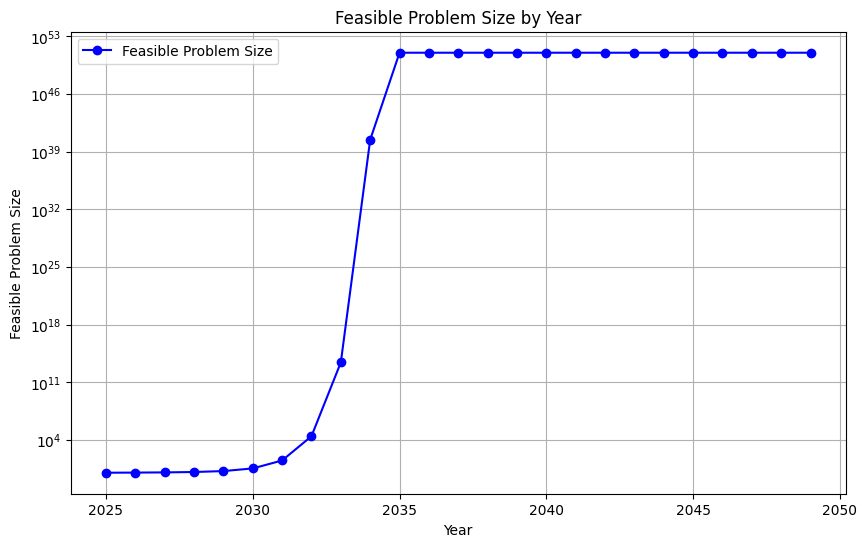

In [4]:
#graph problem_size_qubit_feasible
years = np.arange(2025, 2050)
feasible_sizes = [problem_size_qubit_feasible(roadmap=percentile_90_roadmap, year=year) for year in years]
plt.figure(figsize=(10, 6))
plt.plot(years, feasible_sizes, marker='o', linestyle='-', color='b', label='Feasible Problem Size')
plt.xlabel('Year')
plt.ylabel('Feasible Problem Size')

plt.title('Feasible Problem Size by Year')
plt.grid(True)
plt.legend()
plt.yscale('log')

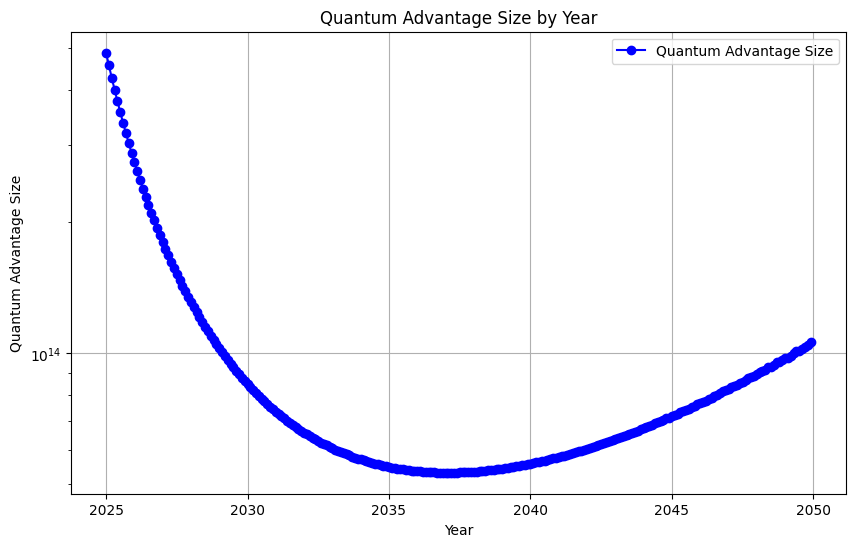

In [5]:

# Define the range of years
# years = range(2025, 2050)
years = np.arange(2025, 2050, 0.1)
# classical_alg_overhead = 1e-5
classical_runtime = "n"
quantum_runtime = "log(n,2)"
# Calculate the quantum advantage size for each year
quantum_advantage_sizes = [quantum_advantage_size_by_year(year, classical_runtime, quantum_runtime) for year in years]

# Filter out None values for plotting
filtered_years = [year for year, size in zip(years, quantum_advantage_sizes) if size is not None]
filtered_sizes = [size for size in quantum_advantage_sizes if size is not None]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(filtered_years, filtered_sizes, marker='o', linestyle='-', color='b', label='Quantum Advantage Size')
plt.xlabel('Year')
plt.ylabel('Quantum Advantage Size')
plt.title('Quantum Advantage Size by Year')
plt.grid(True)
plt.legend()
plt.yscale('log')
plt.show()

# Google_roadmap = {
#     2019: 54,
#     2023: 100,
#     2025: 1000,
# }

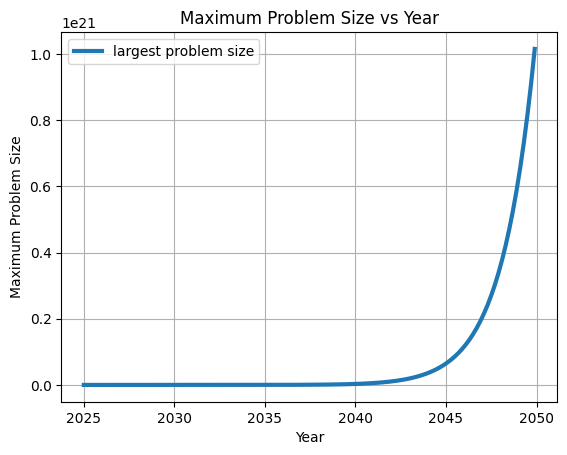

In [6]:

years = np.arange(2025, 2050, 0.1)
quantum_runtime = "n**0.5"
largest_problem_size = [find_largest_problem_size(quantum_runtime, year, roadmap=percentile_90_roadmap, quantum=True, q_prob_size="log", time_upper_limit=1e2) for year in years]
plt.plot(years, largest_problem_size, label="largest problem size", linewidth=3)
plt.xlabel("Year")
plt.ylabel("Maximum Problem Size")
plt.title("Maximum Problem Size vs Year")
plt.legend()
plt.grid(True)


# Continued Error Checking

In [7]:
surface_code_formula(1e-4)

255.99999999999994

In [8]:
# test find largest problem size
runtime_string = "n**8"
year = 2030
# find_largest_problem_size(runtime_expr, year, quantum=True, qadv_only=False, stagnation_year=2200, time_upper_limit=6*1e5)
# binary_search_intersection(lambda x: x**8, lambda x: 6*1e5, 1.0, 1e50)

binary_search_intersection(lambda x: x**8, lambda x: 6*1e5, 1.0, 1e50)


5.275564125789451

# Descriptive Version for Paper 

In [9]:
# Bolder version for poster
classical_runtime_search = "n"
quantum_runtime         = "n**0.5"

# Overhead parameters
alg_overhead_qspeed    = 1.0
alg_overhead_qubit     = 1.0
classical_alg_overhead = 1.0

# Year range
years = np.arange(MIN_YEAR, MAX_YEAR, 0.2)

# Figure setup

roadmap = default_roadmap

# Compute max‐feasible problem size from qubit counts
qubit_feasible_line = [
    problem_size_qubit_feasible(
        roadmap=roadmap,
        year=year,
        q_prob_size="log"
    )
    for year in years
]

# Compute quantum‐compute‐limit line
quantum_problem_sizes = [
    find_largest_problem_size(
        quantum_runtime,
        year,
        quantum=True,
        q_prob_size="log"
    )
    for year in years
]

# Compute Grover QEA line
quantum_economic_advantages_grover = [
    quantum_advantage_size_by_year(
        year,
        classical_runtime_string=classical_runtime_search,
        quantum_runtime_string=quantum_runtime
    )
    for year in years
]

# Show the raw QEA values for debugging/record
print(quantum_economic_advantages_grover)

# Plot QEA line


# Helper functions for intersection search
def _max_problem_size(year):
    return find_largest_problem_size(
        quantum_runtime,
        year,
        quantum=True,
        q_prob_size="log"
    )

def _qea_size(year):
    return quantum_advantage_size_by_year(
        year,
        classical_runtime_string=classical_runtime_search,
        quantum_runtime_string=quantum_runtime
    )

# Find intersection year & value
intersection_year = binary_search_intersection(
    _max_problem_size,
    _qea_size,
    MIN_YEAR,
    MAX_YEAR
)
intersection_value = _max_problem_size(intersection_year)


print("the intersection value is", intersection_value)




[9.999999999999999e+25, 7.743274810422674e+25, 6.101731118255945e+25, 4.884554937760474e+25, 3.966330092391398e+25, 3.262735341819994e+25, 2.7159049692548606e+25, 2.285381831401916e+25, 1.9423950772591525e+25, 1.6661632592890964e+25, 1.4414591700306661e+25, 1.2569769296972219e+25, 1.1042188744945053e+25, 9.767251479442407e+24, 8.695329050001219e+24, 7.787916775372776e+24, 7.014864369561005e+24, 6.352359031279802e+24, 5.781440708164653e+24, 5.286898059540658e+24, 4.856439694069298e+24, 4.4800664725843796e+24, 4.1495920770730886e+24, 3.8582738992023797e+24, 3.6005267149217556e+24, 3.3716989861331604e+24, 3.167896902887493e+24, 2.98584508338761e+24, 2.822775616989148e+24, 2.676339166004046e+24, 2.5445333434464243e+24, 2.425644702121565e+24, 2.3182015093015135e+24, 2.2209351147359222e+24, 2.132748201277478e+24, 2.0526885756884185e+24, 1.979927440539753e+24, 1.9137413073546393e+24, 1.8534968817106714e+24, 1.7986383844074284e+24, 1.7486768776541542e+24, 1.703181248043224e+24, 1.6617705637891

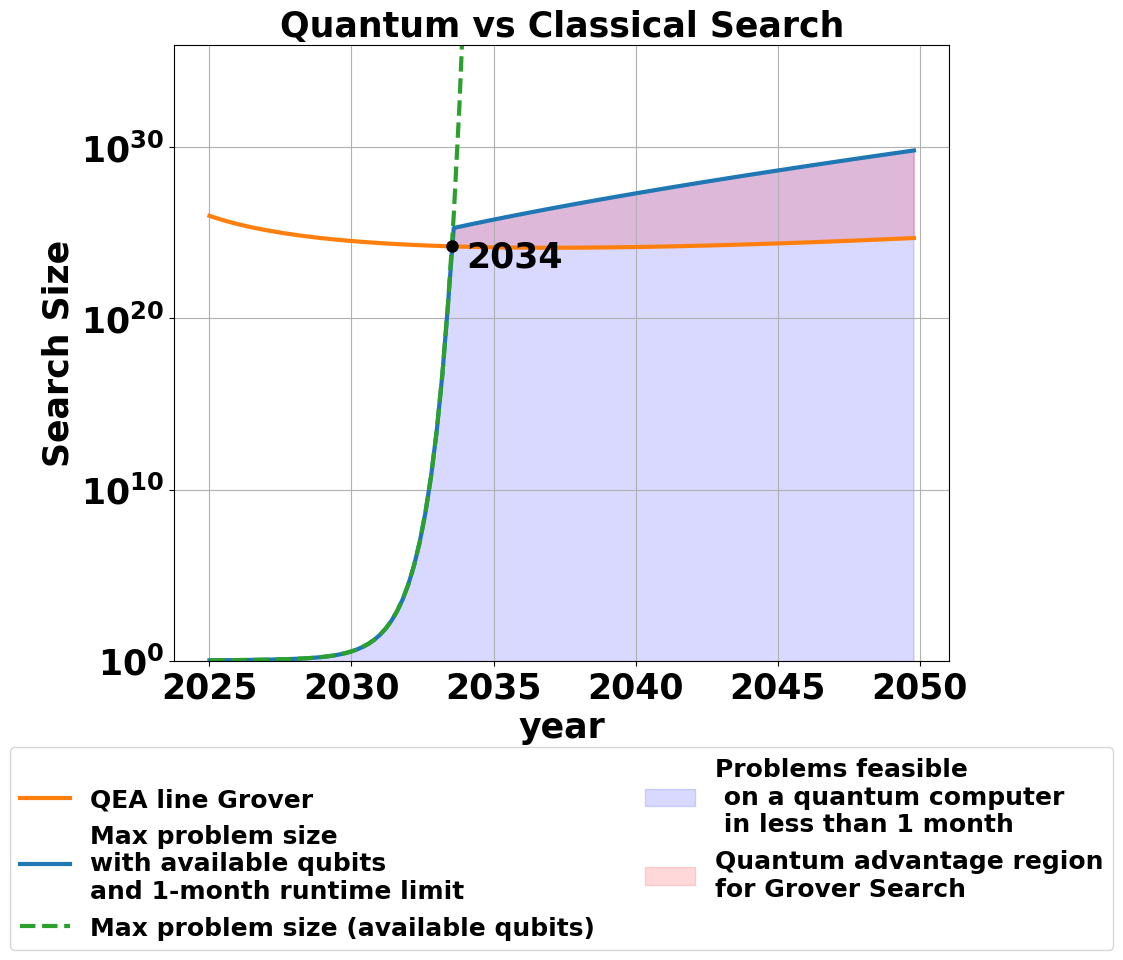

In [10]:

plt.figure(figsize=(10, 8))

plt.plot(
    years,
    quantum_economic_advantages_grover,
    label="QEA line Grover",
    linewidth=3,
    color="tab:orange"
)
# Plot max‐compute line
plt.plot(
    years,
    quantum_problem_sizes,
    label="Max problem size \nwith available qubits \nand 1-month runtime limit",
    linewidth=3,
    color="tab:blue"
)

# Plot qubit-feasible dashed line
plt.plot(
    years,
    qubit_feasible_line,
    label="Max problem size (available qubits)",
    linewidth=3,
    linestyle="--",
    color ="tab:green"
)

# Labels & styling
plt.ylabel("Search Size", fontsize=25, fontweight="bold")
plt.xlabel("year",       fontsize=25, fontweight="bold")


#yticks locations
# yticks = [10**0, 10**10, 10**20, 10**30, 10**40]


# plt.yticks(yticks, fontsize=20, fontweight="bold")

#interesection code: 

def flps(year):
    return find_largest_problem_size(quantum_runtime, year, quantum=True)

def fqas(year):
    return quantum_advantage_size_by_year(year, classical_runtime, quantum_runtime)

intersection_year_grover = binary_search_intersection(flps, fqas, MIN_YEAR, MAX_YEAR)
intersection_value_grover = flps(intersection_year_grover)
plt.plot(intersection_year_grover, intersection_value_grover, "o", color="black", markersize=8)
plt.annotate(
    f"{int(round(intersection_year_grover))}",
    xy=(intersection_year_grover, intersection_value_grover*1e-2),
    xytext=(10, 10),
    textcoords="offset points",
    fontsize=25,
    fontweight="bold",
)






plt.yscale("log")
plt.title("Quantum vs Classical Search", fontsize=25, fontweight="bold")
plt.grid()

# Clamp y-axis


# Fill feasible region
plt.fill_between(
    years,
    0,
    quantum_problem_sizes,
    color="blue",
    alpha=0.15,
    label="Problems feasible \n on a quantum computer \n in less than 1 month"
)

# Fill advantage region
plt.fill_between(
    years,
    quantum_economic_advantages_grover,
    quantum_problem_sizes,
    color="red",
    alpha=0.15,
    label="Quantum advantage region\nfor Grover Search",
    where=(
        np.array(quantum_problem_sizes) >=
        np.array(quantum_economic_advantages_grover)
    )
)

# Legend below plot
legend = plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.12),
    ncol=2,
    fontsize=18
)
plt.setp(legend.get_texts(), fontweight='bold')
yticks = [10.0**0, 10.0**10, 10.0**20, 10.0**30]
yticklabels = [r"$\mathbf{10^0}$", r"$\mathbf{10^{10}}$", r"$\mathbf{10^{20}}$", r"$\mathbf{10^{30}}$"]
plt.yticks(yticks, yticklabels, fontsize=25)
plt.xticks(fontsize=25, fontweight="bold")
plt.ylim(1e0, MAX_PROBLEM_SIZE/1e15)
# Final layout & save
# plt.tight_layout(rect=[0, 0, 1, 0.95], pad=1.5)
plt.savefig(
    "Figures/generalized_qea_model.png",
    bbox_inches="tight",
    dpi=300
)
plt.show()

# Quantum Advantage Search Plot

/Users/hansgundlach/Documents/AllOtherResearch/NeelMaterial/othello/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


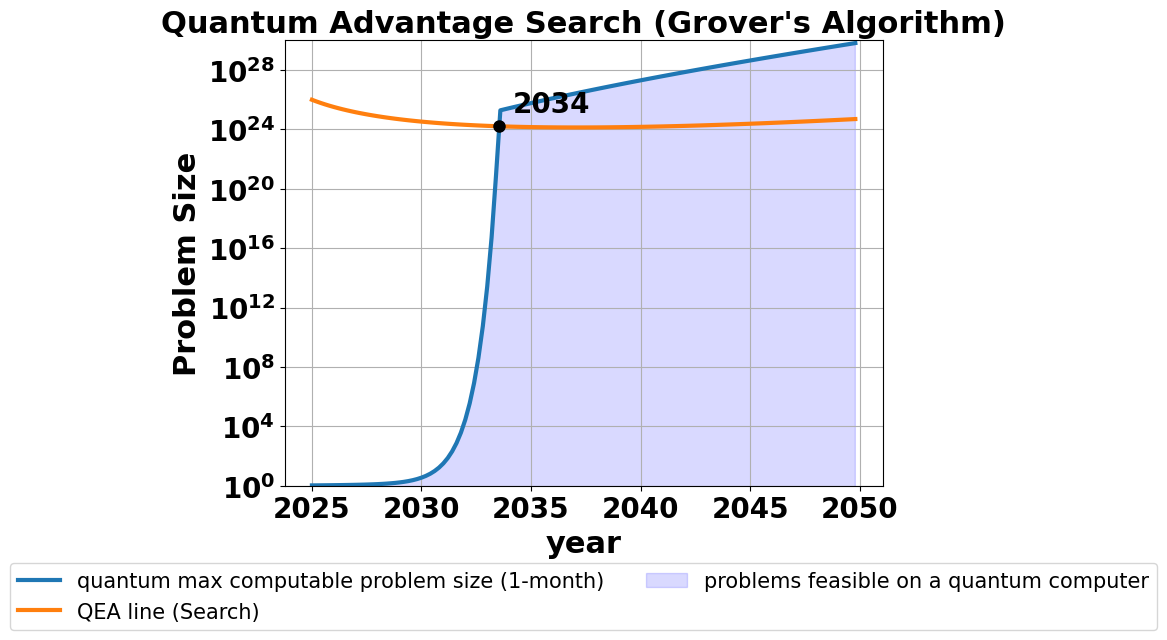

<Figure size 640x480 with 0 Axes>

In [24]:


# 1) Define the years and runtimes
years = np.arange(2025, 2050, 0.2)
classical_runtime = "n"
quantum_runtime   = "n**0.5"

# 3) Find the intersection point
def flps(year):
    return find_largest_problem_size(quantum_runtime, year, quantum=True)

def fqas(year):
    return quantum_advantage_size_by_year(year, classical_runtime, quantum_runtime)

# 2) Compute the two curves
quantum_problem_sizes_grover = [
    find_largest_problem_size(quantum_runtime, year, quantum=True)
    for year in years
]
quantum_economic_advantages_grover = [
    quantum_advantage_size_by_year(year, classical_runtime, quantum_runtime)
    for year in years
]

# 3) Find the intersection point
def flps(year):
    return find_largest_problem_size(quantum_runtime, year, quantum=True)

def fqas(year):
    return quantum_advantage_size_by_year(year, classical_runtime, quantum_runtime)

intersection_year_grover = binary_search_intersection(flps, fqas, MIN_YEAR, MAX_YEAR)
intersection_value_grover = flps(intersection_year_grover)

# 4) Plot
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(
    years,
    quantum_problem_sizes_grover,
    label="quantum max computable problem size (1-month)",
    linewidth=3,
)
ax.plot(
    years,
    quantum_economic_advantages_grover,
    label="QEA line (Search)",
    linewidth=3,
)
ax.fill_between(
    years,
    0,
    quantum_problem_sizes_grover,
    color="blue",
    alpha=0.15,
    label="problems feasible on a quantum computer",
)

# mark & annotate the intersection
ax.plot(intersection_year_grover, intersection_value_grover, "o", color="black", markersize=8)
ax.annotate(
    f"{int(round(intersection_year_grover))}",
    xy=(intersection_year_grover, intersection_value_grover),
    xytext=(10, 10),
    textcoords="offset points",
    fontsize=20,
    fontweight="bold",
)

# styling to match your 3-panel figure
ax.set_xlabel("year", fontsize=22, fontweight="bold")
ax.set_ylabel("Problem Size", fontsize=22, fontweight="bold")
ax.set_title("Quantum Advantage Search (Grover's Algorithm)", fontsize=22, fontweight="bold")
ax.set_yscale("log")
ax.grid(True)

ax.tick_params(axis="both", which="major", labelsize=20)
for lbl in ax.get_xticklabels() + ax.get_yticklabels():
    lbl.set_fontweight("bold")

# single legend below plot
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    fontsize=15,
)
plt.ylim(1e0, 1e30)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()
plt.savefig("Figures/qea_grover.png")

# Plot of Linear_to_Log Advantage

2033.0245721976098
60436939550311.35 intersection value


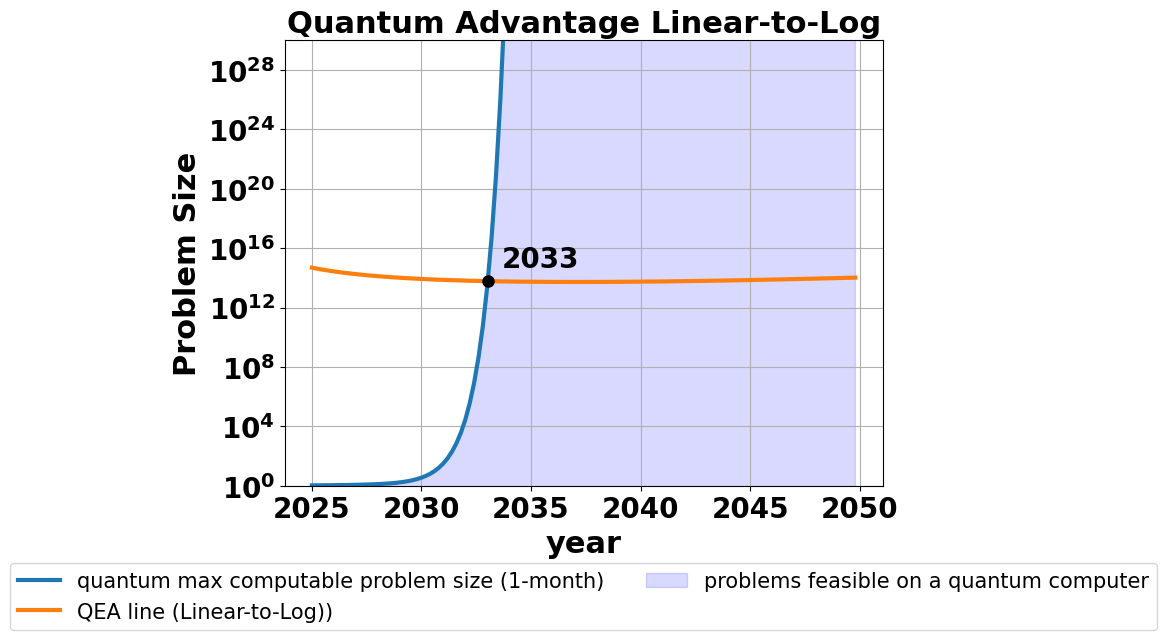

<Figure size 640x480 with 0 Axes>

In [25]:
#cursor please generate a print statement to say print hello

# 1) Define the years and runtimes
years = np.arange(2025, 2050, 0.2)
classical_runtime = "n"
quantum_runtime   = "log(n,2)"

# 2) Compute the two curves
quantum_problem_sizes_lin_log = [
    find_largest_problem_size(quantum_runtime, year, quantum=True)
    for year in years
]
quantum_economic_advantages_lin_log = [
    quantum_advantage_size_by_year(year, classical_runtime, quantum_runtime)
    for year in years
]

# 3) Find the intersection point
def flps(year):
    return find_largest_problem_size(quantum_runtime, year, quantum=True)

def fqas(year):
    return quantum_advantage_size_by_year(year, classical_runtime, quantum_runtime)

intersection_year_lin_log = binary_search_intersection(flps, fqas, MIN_YEAR, MAX_YEAR)
intersection_value_lin_log = flps(intersection_year_lin_log)
print(intersection_year_lin_log)
print(intersection_value_lin_log, "intersection value")

# 4) Plot
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(
    years,
    quantum_problem_sizes_lin_log,
    label="quantum max computable problem size (1-month)",
    linewidth=3,
)
ax.plot(
    years,
    quantum_economic_advantages_lin_log,
    label="QEA line (Linear-to-Log))",
    linewidth=3,
)
ax.fill_between(
    years,
    0,
    quantum_problem_sizes_lin_log,
    color="blue",
    alpha=0.15,
    label="problems feasible on a quantum computer",
)

# mark & annotate the intersection
ax.plot(intersection_year_lin_log, intersection_value_lin_log, "o", color="black", markersize=8)
ax.annotate(
    f"{int(round(intersection_year_lin_log))}",
    xy=(intersection_year_lin_log, intersection_value_lin_log),
    xytext=(10, 10),
    textcoords="offset points",
    fontsize=20,
    fontweight="bold",
)

# styling to match your 3-panel figure
ax.set_xlabel("year", fontsize=22, fontweight="bold")
ax.set_ylabel("Problem Size", fontsize=22, fontweight="bold")
ax.set_title("Quantum Advantage Linear-to-Log", fontsize=22, fontweight="bold")
ax.set_yscale("log")
ax.grid(True)

ax.tick_params(axis="both", which="major", labelsize=20)
for lbl in ax.get_xticklabels() + ax.get_yticklabels():
    lbl.set_fontweight("bold")

# single legend below plot
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    fontsize=15,
)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.ylim(1e0,1e30)
plt.show()
plt.savefig("Figures/qea_linear_log.png")

## Matrix Multiplication Quantum Advantage

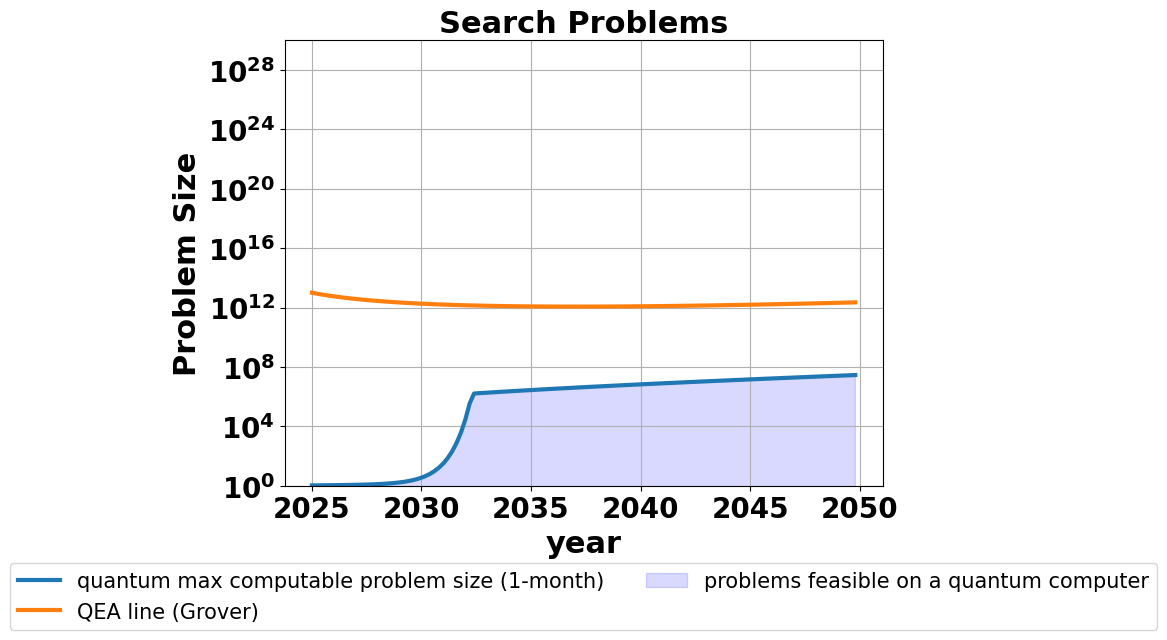

<Figure size 640x480 with 0 Axes>

In [26]:


# 1) Define the years and runtimes
years = np.arange(2025, 2050, 0.2)
classical_runtime = "n**3"
quantum_runtime   = "n**2"

# 2) Compute the two curves
quantum_problem_sizes_mat_mul = [
    find_largest_problem_size(quantum_runtime, year, quantum=True)
    for year in years
]
quantum_economic_advantages_mat_mul = [
    quantum_advantage_size_by_year(year, classical_runtime, quantum_runtime)
    for year in years
]

# 4) Plot
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(
    years,
    quantum_problem_sizes_mat_mul,
    label="quantum max computable problem size (1-month)",
    linewidth=3,
)
ax.plot(
    years,
    quantum_economic_advantages_mat_mul,
    label="QEA line (Grover)",
    linewidth=3,
)
ax.fill_between(
    years,
    0,
    quantum_problem_sizes_mat_mul,
    color="blue",
    alpha=0.15,
    label="problems feasible on a quantum computer",
)

# styling to match your 3-panel figure
ax.set_xlabel("year", fontsize=22, fontweight="bold")
ax.set_ylabel("Problem Size", fontsize=22, fontweight="bold")
ax.set_title("Search Problems", fontsize=22, fontweight="bold")
ax.set_yscale("log")
ax.grid(True)

ax.tick_params(axis="both", which="major", labelsize=20)
for lbl in ax.get_xticklabels() + ax.get_yticklabels():
    lbl.set_fontweight("bold")

# single legend below plot
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,                         
    fontsize=15,
)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.ylim(1e0,1e30)
plt.show()
plt.savefig("Figures/qea_matrix_mult.png")

##  Combined Plot

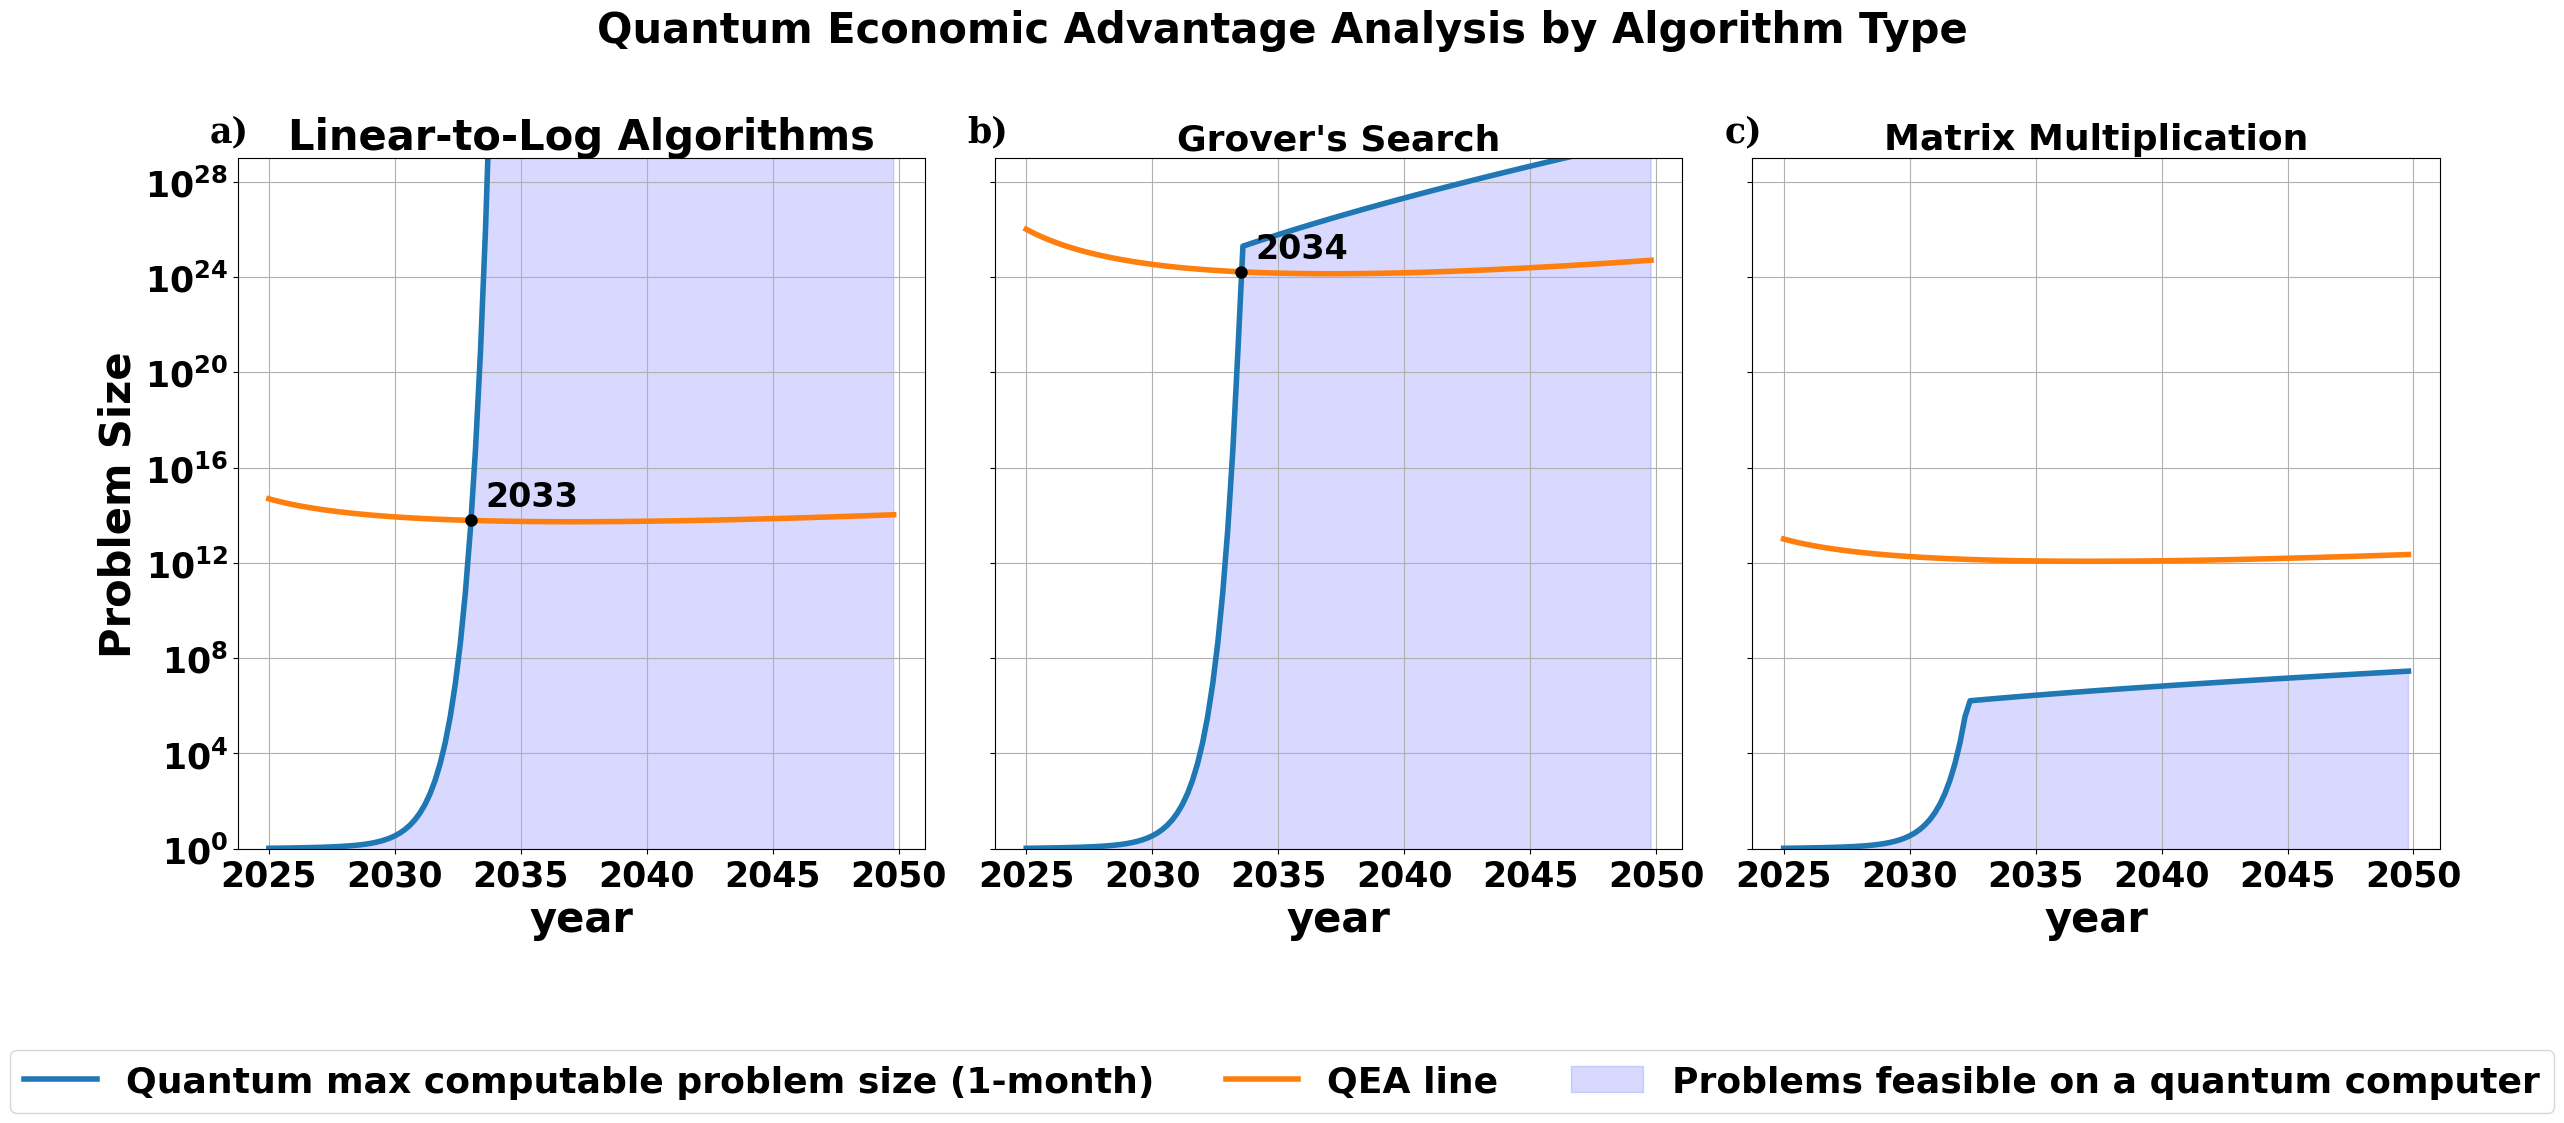

In [27]:
# Create a multi-panel figure combining the three individual graphs
import matplotlib.pyplot as plt
from matplotlib.transforms import ScaledTranslation

# Common parameters
annotation_size = 24

# Create figure with three panels
# fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharey=True)
fig, axes = plt.subplots(1, 3, figsize=(24, 11), sharey=True)

# Add subplot labels
for i, ax in enumerate(axes):
    label = chr(97 + i) + ')'  # 'a)', 'b)', 'c)'
    ax.text(
        0.0, 1.0, label, 
        transform=(ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
        fontsize=25, fontweight='bold', va='bottom', fontfamily='serif'
    )

# ========== PANEL 1: LINEAR-TO-LOG ADVANTAGE ==========
axes[0].plot(
    years,
    quantum_problem_sizes_lin_log,
    label="Quantum max computable problem size (1-month)",
    linewidth=4,
)
axes[0].plot(
    years,
    quantum_economic_advantages_lin_log,
    label="QEA line",
    linewidth=4,
)
axes[0].fill_between(
    years,
    0,
    quantum_problem_sizes_lin_log,
    color="blue",
    alpha=0.15,
    label="Problems feasible on a quantum computer",
)

# Plot intersection point
axes[0].plot(intersection_year_lin_log, intersection_value_lin_log, "o", color="black", markersize=8)
axes[0].annotate(
    f"{int(round(intersection_year_lin_log))}",
    xy=(intersection_year_lin_log, intersection_value_lin_log),
    xytext=(10, 10),
    textcoords="offset points",
    fontsize=annotation_size,
    fontweight="bold",
)

# Title from your individual graph
axes[0].set_title("Linear-to-Log Algorithms", fontsize=30, fontweight="bold")
axes[0].set_xlabel("year", fontsize=30, fontweight="bold")
axes[0].set_ylabel("Problem Size", fontsize=30, fontweight="bold")

# ========== PANEL 2: SEARCH/GROVER'S ALGORITHM ==========
axes[1].plot(
    years,
    quantum_problem_sizes_grover,
    label="Quantum max computable problem size (1-month)",
    linewidth=4,
)
axes[1].plot(
    years,
    quantum_economic_advantages_grover,
    label="QEA line",
    linewidth=4,
)
axes[1].fill_between(
    years,
    0,
    quantum_problem_sizes_grover,
    color="blue",
    alpha=0.15,
    label="Problems feasible on a quantum computer",
)

# Plot intersection point
axes[1].plot(intersection_year_grover, intersection_value_grover, "o", color="black", markersize=8)
axes[1].annotate(
    f"{int(round(intersection_year_grover))}",
    xy=(intersection_year_grover, intersection_value_grover),
    xytext=(10, 10),
    textcoords="offset points",
    fontsize=annotation_size,
    fontweight="bold",
)

# Title from your individual graph
axes[1].set_title("Grover's Search", fontsize=26, fontweight="bold")
axes[1].set_xlabel("year", fontsize=30, fontweight="bold")

# ========== PANEL 3: MATRIX MULTIPLICATION ==========
axes[2].plot(
    years,
    quantum_problem_sizes_mat_mul,
    label="Quantum max computable problem size (1-month)",
    linewidth=4,
)
axes[2].plot(
    years,
    quantum_economic_advantages_mat_mul,
    label="QEA line",
    linewidth=4,  # Match the color from your combined plot
)
axes[2].fill_between(
    years,
    0,
    quantum_problem_sizes_mat_mul,
    color="blue",
    alpha=0.15,
    label="Problems feasible on a quantum computer",
)

# Title from your individual graph
axes[2].set_title("Matrix Multiplication", fontsize=26, fontweight="bold")
axes[2].set_xlabel("year", fontsize=30, fontweight="bold")

# ========== COMMON FORMATTING FOR ALL PANELS ==========
for ax in axes:
    # Apply common styling
    ax.set_yscale("log")
    ax.set_ylim(1e0, 1e30/10)
    ax.grid(True)
    
    # Bold ticks
    ax.tick_params(axis="both", which="major", labelsize=25)
    for lbl in ax.get_xticklabels() + ax.get_yticklabels():
        lbl.set_fontweight("bold")

# Common legend for all subplots
handles, labels = axes[0].get_legend_handles_labels()
prop = {"size": 26, "weight": "bold"}
fig.legend(
    handles, labels, 
    loc="upper center", 
    bbox_to_anchor=(0.5, 0.05), 
    ncol=3, 
    prop=prop
)

# Add overall title
fig.suptitle(
    "Quantum Economic Advantage Analysis by Algorithm Type", 
    fontsize=30, fontweight="bold", y=0.98
)


# Adjust layout and save
plt.tight_layout(rect=[0, 0.12, 1, 0.95])
plt.savefig("figures/quantum_advantage_comparison.png", bbox_inches="tight", dpi=300)
plt.show()

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_17796/1693243009.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 0.95])


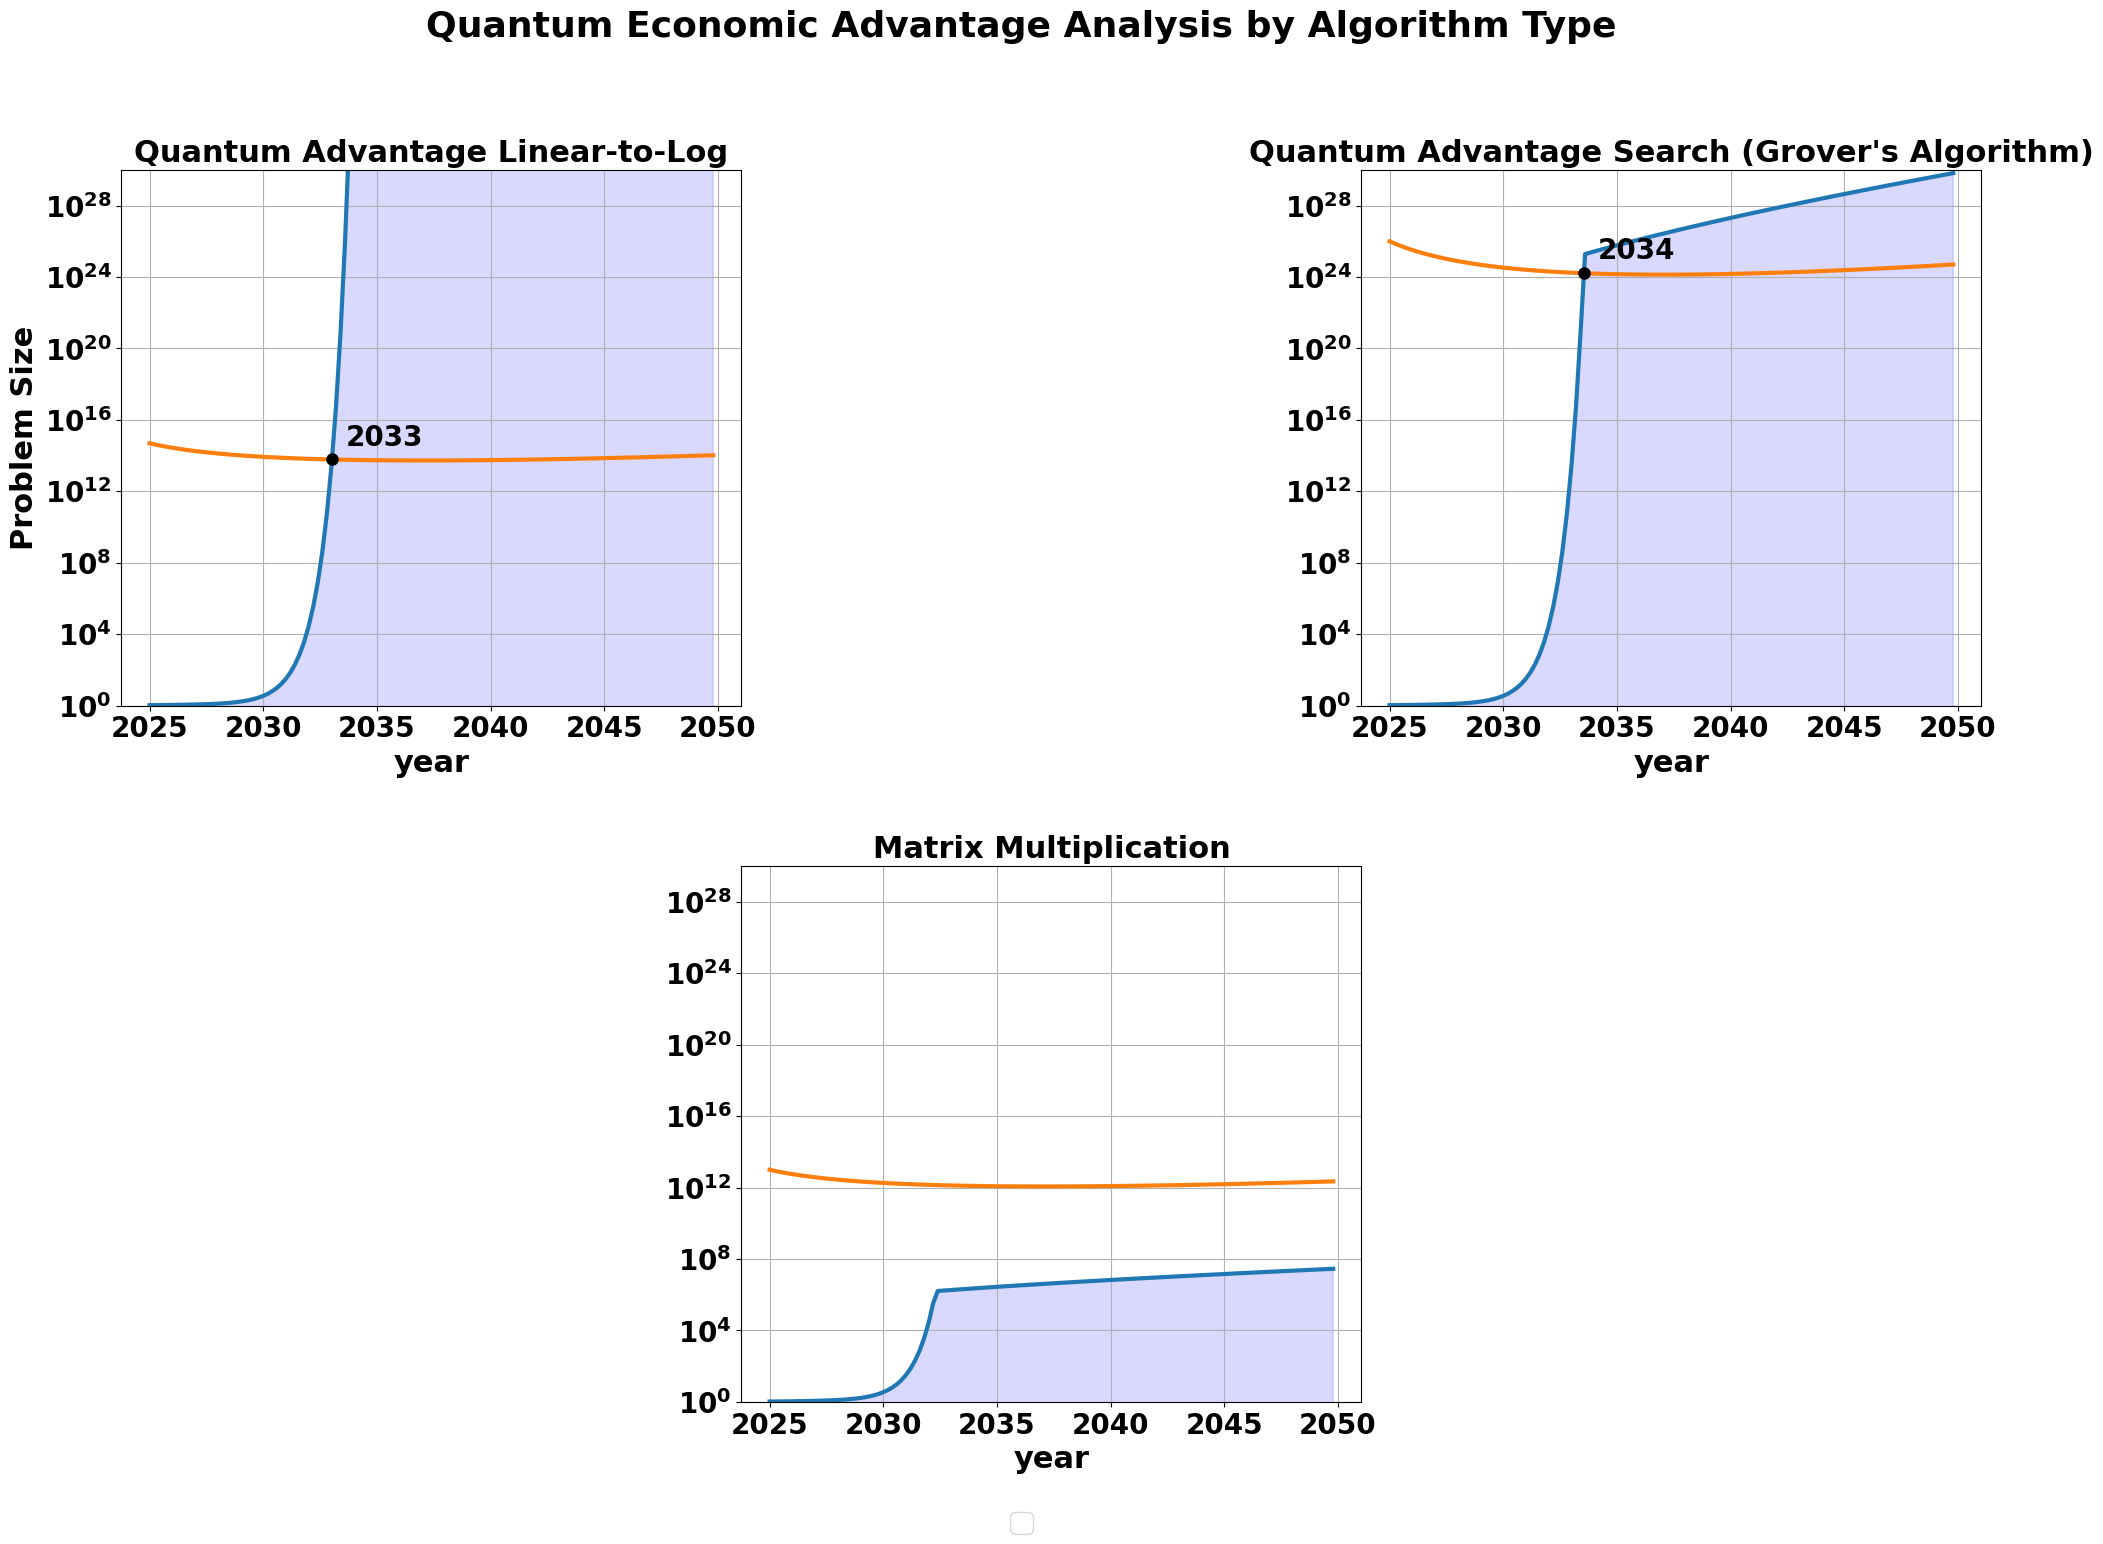

In [28]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Common parameters
annotation_size = 20

# Create a figure with a 2×3 GridSpec
fig = plt.figure(figsize=(24, 16))
# gs  = fig.add_gridspec(2, 3, height_ratios=[1, 1], width_ratios=[1, 1, 1],
gs  = fig.add_gridspec(
    2, 3,
    height_ratios=[1, 1],
    width_ratios=[1, 1, 1],   # equal widths for all three columns
    hspace=0.3,               # vertical padding
    wspace=0.00              # very little horizontal padding
)


# Top row: two side-by-side plots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 2], sharey=ax1)

# Bottom row: one centered plot
ax3 = fig.add_subplot(gs[1, 1], sharey=ax1)

# === PANEL 1 ===
ax1.plot(years, quantum_problem_sizes_lin_log,    linewidth=3)
ax1.plot(years, quantum_economic_advantages_lin_log, linewidth=3)
ax1.fill_between(years, 0, quantum_problem_sizes_lin_log, color="blue", alpha=0.15)
ax1.plot(intersection_year_lin_log, intersection_value_lin_log, "o", color="black", markersize=8)
ax1.annotate(f"{int(round(intersection_year_lin_log))}",
             xy=(intersection_year_lin_log, intersection_value_lin_log),
             xytext=(10, 10), textcoords="offset points",
             fontsize=annotation_size, fontweight="bold")
ax1.set_title("Quantum Advantage Linear-to-Log", fontsize=22, fontweight="bold")
ax1.set_xlabel("year", fontsize=22, fontweight="bold")
ax1.set_ylabel("Problem Size", fontsize=22, fontweight="bold")

# === PANEL 2 ===
ax2.plot(years, quantum_problem_sizes_grover,    linewidth=3)
ax2.plot(years, quantum_economic_advantages_grover, linewidth=3)
ax2.fill_between(years, 0, quantum_problem_sizes_grover, color="blue", alpha=0.15)
ax2.plot(intersection_year_grover, intersection_value_grover, "o", color="black", markersize=8)
ax2.annotate(f"{int(round(intersection_year_grover))}",
             xy=(intersection_year_grover, intersection_value_grover),
             xytext=(10, 10), textcoords="offset points",
             fontsize=annotation_size, fontweight="bold")
ax2.set_title("Quantum Advantage Search (Grover's Algorithm)", fontsize=22, fontweight="bold")
ax2.set_xlabel("year", fontsize=22, fontweight="bold")

# === PANEL 3 ===
ax3.plot(years, quantum_problem_sizes_mat_mul,    linewidth=3)
ax3.plot(years, quantum_economic_advantages_mat_mul, linewidth=3)
ax3.fill_between(years, 0, quantum_problem_sizes_mat_mul, color="blue", alpha=0.15)
ax3.set_title("Matrix Multiplication", fontsize=22, fontweight="bold")
ax3.set_xlabel("year", fontsize=22, fontweight="bold")

# === COMMON FORMATTING ===
for ax in (ax1, ax2, ax3):
    ax.set_yscale("log")
    ax.set_ylim(1e0, 1e30)
    ax.grid(True)
    ax.tick_params(axis="both", which="major", labelsize=20)
    for lbl in ax.get_xticklabels() + ax.get_yticklabels():
        lbl.set_fontweight("bold")

# Legend and overall title
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 0.05),
           ncol=3, prop={"size": 20, "weight": "bold"})
fig.suptitle("Quantum Economic Advantage Analysis by Algorithm Type",
             fontsize=26, fontweight="bold", y=0.98)

plt.tight_layout(rect=[0, 0.12, 1, 0.95])
plt.savefig("Figures/quantum_advantage_triangle.png", bbox_inches="tight", dpi=300)
plt.show()